# Structure Reprojections on image

Particle locations and orientations found using 2DTM are re-projected onto a micrograph.

In [1]:
import os

import pandas as pd
import mrcfile
import numpy as np
import torch
from scipy.signal import wiener
import matplotlib.pyplot as plt

from leopard_em.utils.fourier_slice import get_real_space_projections_from_volume

### Loading in micrograph

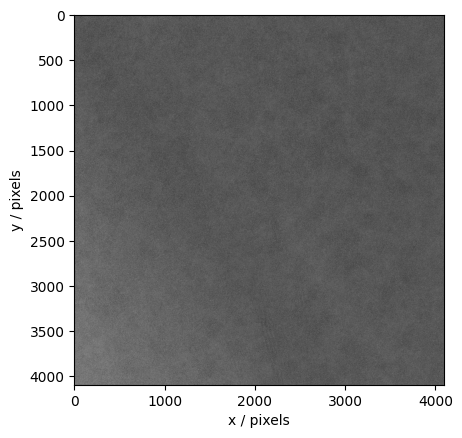

In [2]:
micrograph_path = (
    "/data/papers/2025_Leopard-EM/xe30kv/mgraphs_25/xenon_219_000_0.0_DWS.mrc"
)

micrograph = mrcfile.open(micrograph_path, mode="r").data.copy()

# Show the micrograph
plt.imshow(micrograph, cmap="gray")
plt.xlabel("x / pixels")
plt.ylabel("y / pixels")
plt.show()

### Loading in picked particle results to DataFrame

In [3]:
result_dir = "/data/papers/2025_Leopard-EM/xe30kv/results_match_tm_60S"
results_prefix = micrograph_path.split("/")[-1]
results_prefix = results_prefix.replace(".mrc", "_results.csv")


with open(f"{result_dir}/{results_prefix}", "r") as f:
    df = pd.read_csv(f)

df = df[df["scaled_mip"] > 9]
df

Unnamed: 0  particle_index        mip  scaled_mip  correlation_mean  \
0             0               0  16.941252   15.233522          0.020207   
1             1               1  13.567871   13.574046          0.117597   
2             2               2  13.711670   13.124782          0.064889   
3             3               3  14.027561   12.833559          0.001663   
4             4               4  12.994080   12.787164          0.060302   
..          ...             ...        ...         ...               ...   
204         204             204   9.305277    9.044969          0.009143   
205         205             205   8.906158    9.032830          0.025153   
206         206             206   8.944157    9.017300          0.011531   
207         207             207   9.091574    9.008350          0.073628   
208         208             208   9.359785    9.007197          0.107476   

     correlation_variance  total_correlations  pos_x  pos_y  pos_x_img  ...  \
0                1.110777            20598240     66   2729        322  ...   
1                0.990882            20598240   2677    756       2933  ...   
2                1.039772            20598240    250   1331        506  ...   
3                1.092908            20598240    211   2672        467  ...   
4                1.011466            20598240   2350   2013       2606  ...   
..                    ...                 ...    ...    ...        ...  ...   
204              1.027769            20598240    727   2121        983  ...   
205              0.983192            20598240   2115   3390       2371  ...   
206              0.990610            20598240   2982   2729       3238  ...   
207              1.001065            20598240   3049   3023       3305  ...   
208              1.027213            20598240   1707   1563       1963  ...   

                                       micrograph_path  \
0    /global/scratch/users/jdickerson/2dtm_test_dat...   
1    /global/scratch/users/jdickerson/2dtm_test_dat...   
2    /global/scratch/users/jdickerson/2dtm_test_dat...   
3    /global/scratch/users/jdickerson/2dtm_test_dat...   
4    /global/scratch/users/jdickerson/2dtm_test_dat...   
..                                                 ...   
204  /global/scratch/users/jdickerson/2dtm_test_dat...   
205  /global/scratch/users/jdickerson/2dtm_test_dat...   
206  /global/scratch/users/jdickerson/2dtm_test_dat...   
207  /global/scratch/users/jdickerson/2dtm_test_dat...   
208  /global/scratch/users/jdickerson/2dtm_test_dat...   

                                         template_path  \
0    /global/scratch/users/jdickerson/2dtm_test_dat...   
1    /global/scratch/users/jdickerson/2dtm_test_dat...   
2    /global/scratch/users/jdickerson/2dtm_test_dat...   
3    /global/scratch/users/jdickerson/2dtm_test_dat...   
4    /global/scratch/users/jdickerson/2dtm_test_dat...   
..                                                 ...   
204  /global/scratch/users/jdickerson/2dtm_test_dat...   
205  /global/scratch/users/jdickerson/2dtm_test_dat...   
206  /global/scratch/users/jdickerson/2dtm_test_dat...   
207  /global/scratch/users/jdickerson/2dtm_test_dat...   
208  /global/scratch/users/jdickerson/2dtm_test_dat...   

                                              mip_path  \
0    /global/scratch/users/jdickerson/2dtm_test_dat...   
1    /global/scratch/users/jdickerson/2dtm_test_dat...   
2    /global/scratch/users/jdickerson/2dtm_test_dat...   
3    /global/scratch/users/jdickerson/2dtm_test_dat...   
4    /global/scratch/users/jdickerson/2dtm_test_dat...   
..                                                 ...   
204  /global/scratch/users/jdickerson/2dtm_test_dat...   
205  /global/scratch/users/jdickerson/2dtm_test_dat...   
206  /global/scratch/users/jdickerson/2dtm_test_dat...   
207  /global/scratch/users/jdickerson/2dtm_test_dat...   
208  /global/scratch/users/jdickerson/2dtm_test_dat...   

                                       scaled_mip_pa

### Preparing volume to take Fourier slices from

In [4]:
template_volume_path = "/data/papers/2025_Leopard-EM/maps/60S_map_px0.936_bscale0.5.mrc"
template_volume = mrcfile.open(template_volume_path, mode="r").data.copy()
template_volume = torch.from_numpy(template_volume)
template_volume.shape

torch.Size([512, 512, 512])

In [5]:
# Generating the projections
reprojections = get_real_space_projections_from_volume(
    volume=template_volume,
    phi=torch.from_numpy(df["phi"].values).float(),
    theta=torch.from_numpy(df["theta"].values).float(),
    psi=torch.from_numpy(df["psi"].values).float(),
    degrees=True,
)

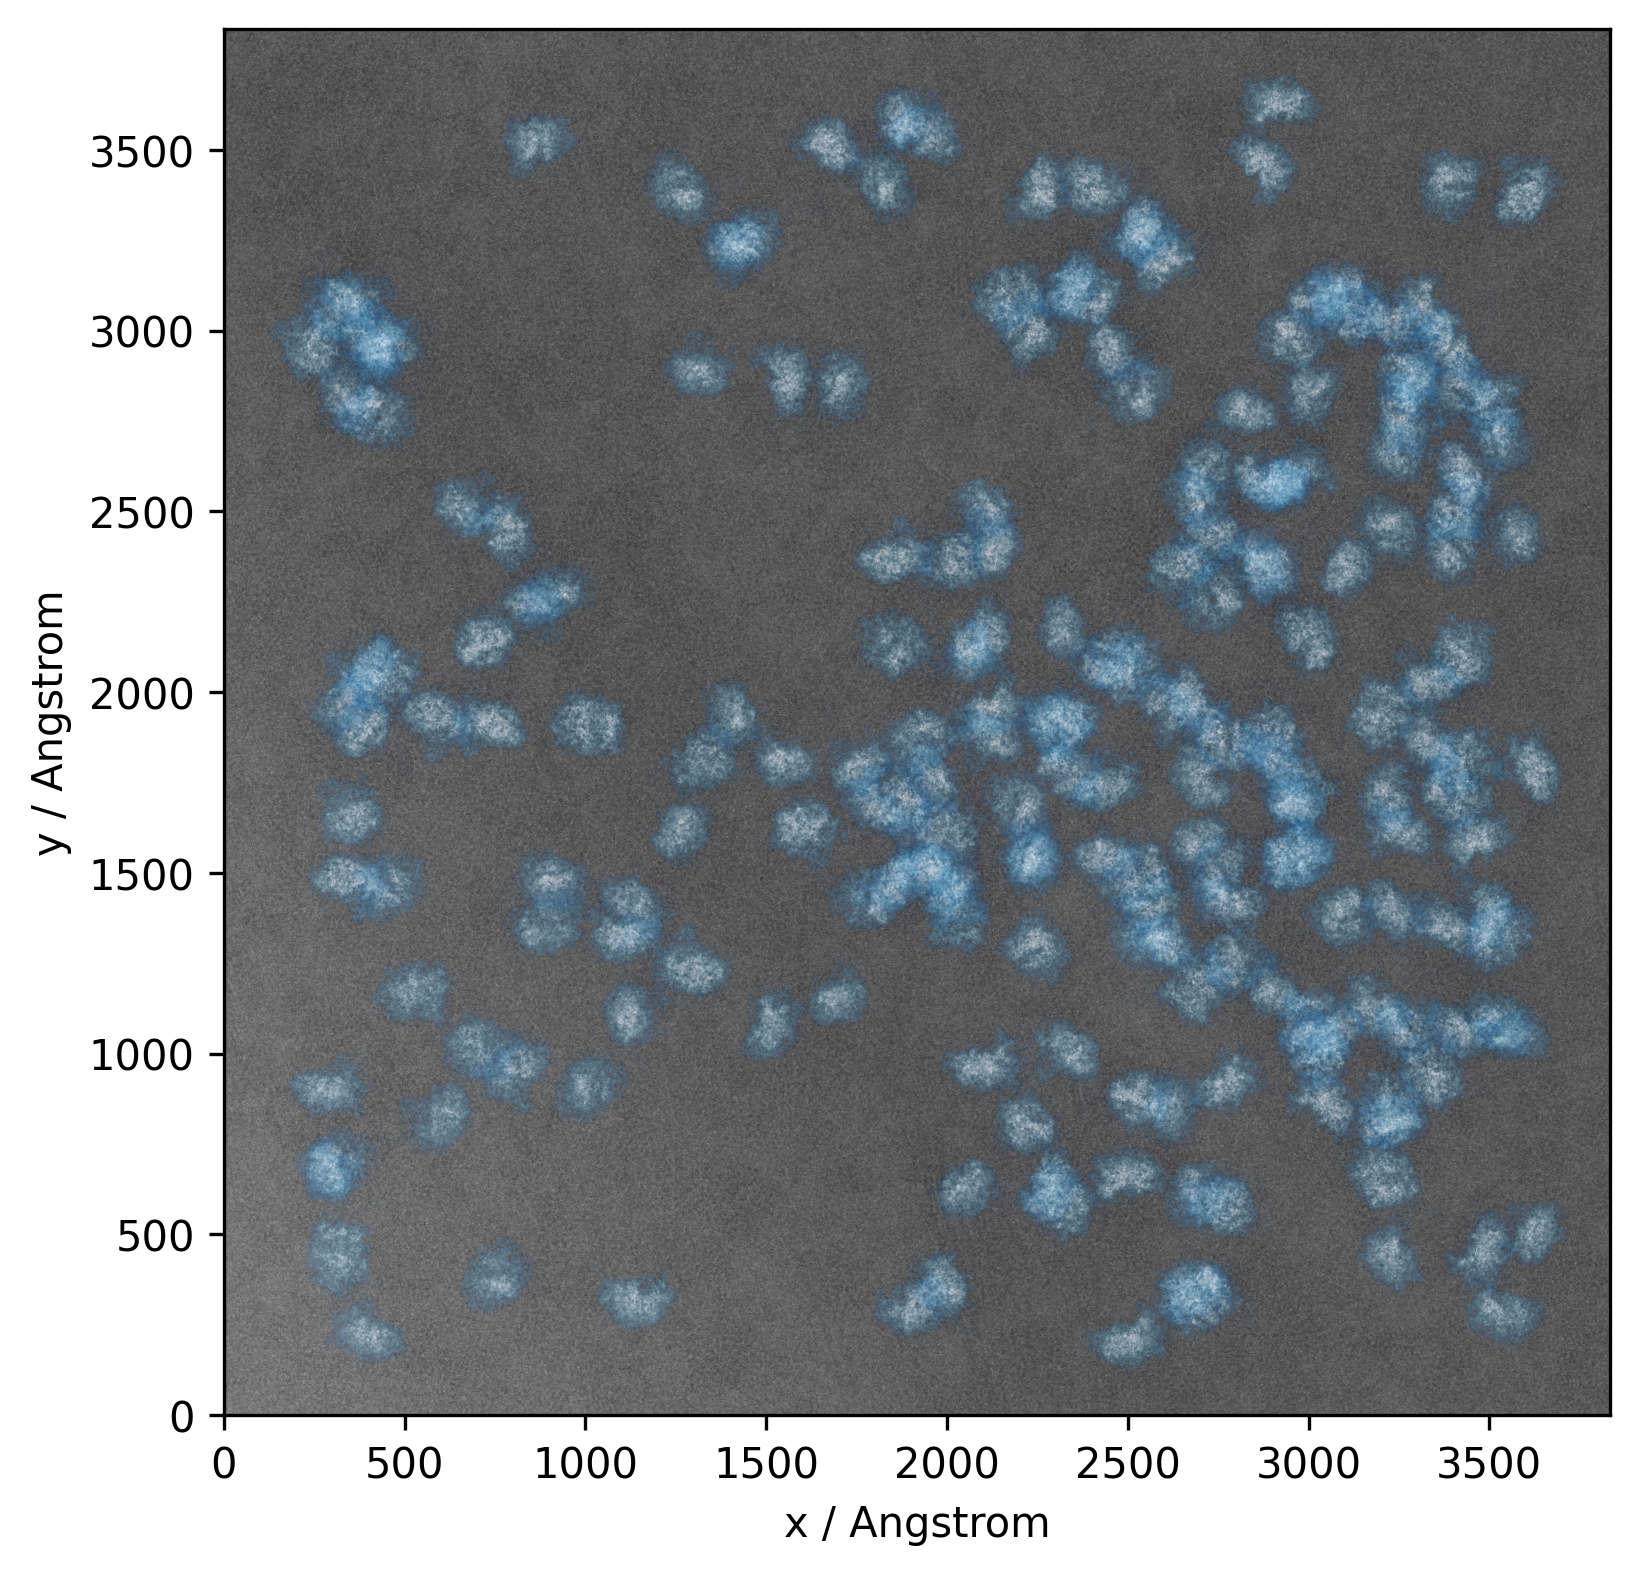

In [6]:
# img = wiener(micrograph, mysize=20)
img = micrograph.copy()

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

ax.imshow(img, cmap="gray", extent=[0, img.shape[1] * 0.936, 0, img.shape[0] * 0.936])

for i in range(reprojections.shape[0]):
    x = df["pos_x"].values[i]
    y = df["pos_y"].values[i]

    projection = reprojections[i].numpy()
    height, width = projection.shape
    extent = [x * 0.936, (x + width) * 0.936, y * 0.936, (y + height) * 0.936]

    # Apply a circular mask to the projection
    mask = np.zeros_like(projection)
    h, w = mask.shape
    y, x = np.ogrid[:h, :w]
    r = np.sqrt((x - w // 2) ** 2 + (y - h // 2) ** 2)
    mask_area = r < 0.33 * min(h, w)
    mask[mask_area] = 1

    projection = projection - projection.min()
    projection = projection / projection.max()
    normed_projection = 1 - projection
    projection = plt.cm.Blues(projection)
    projection[..., 3] = normed_projection * 0.8  # set alpha channel

    ax.imshow(projection * mask[..., None], cmap="gray", extent=extent)

plt.xlim(0, img.shape[1] * 0.936)
plt.ylim(0, img.shape[0] * 0.936)
plt.xlabel("x / Angstrom")
plt.ylabel("y / Angstrom")
plt.show()

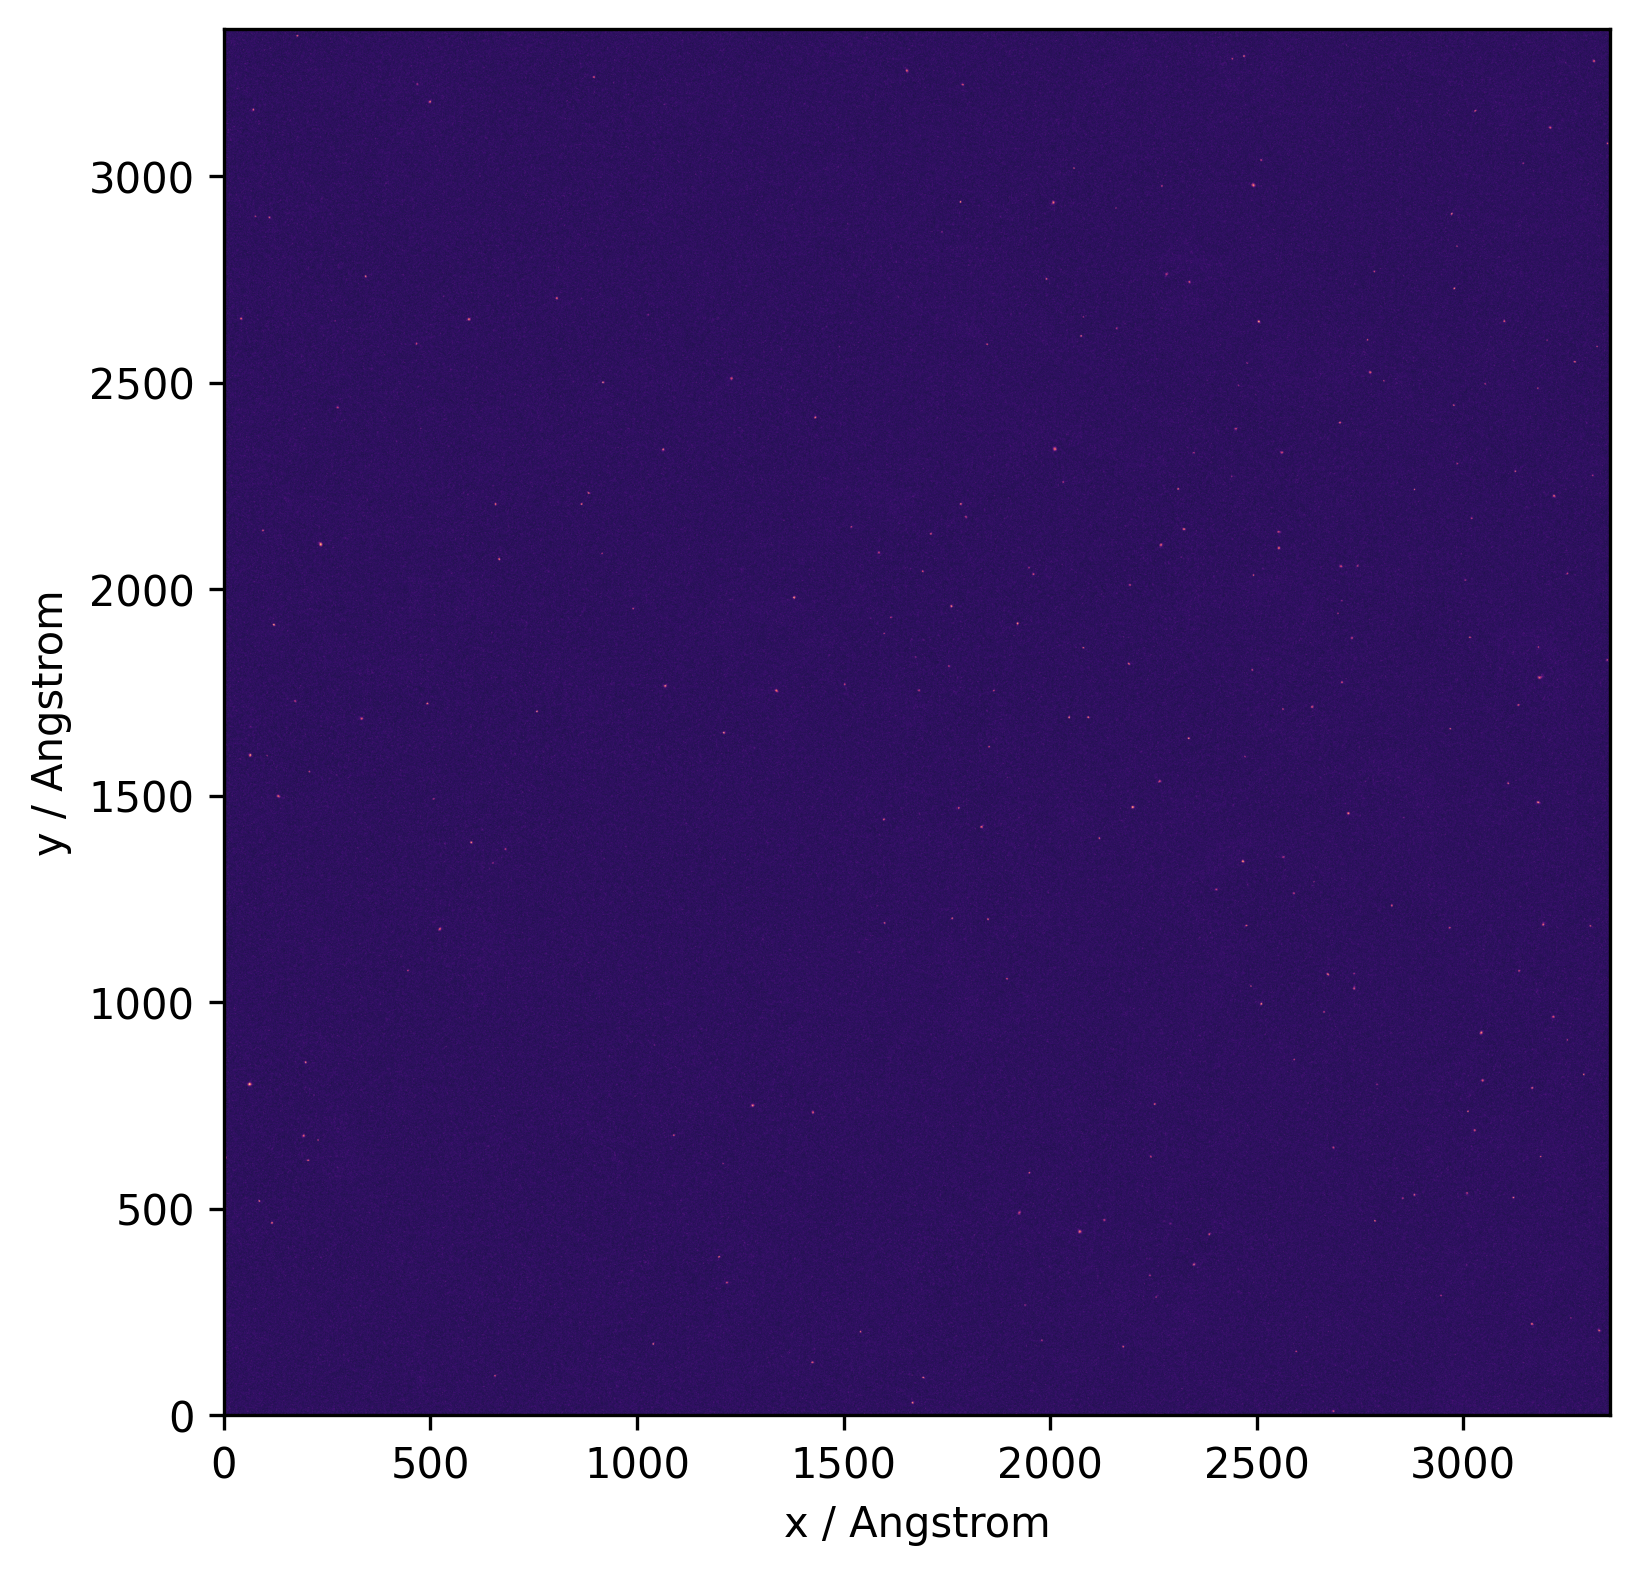

In [14]:
# Plot the scaled mip
results_prefix = micrograph_path.split("/")[-1]
scaled_mip_path = (
    f"{result_dir}/{results_prefix.replace('.0_DWS.mrc', '_output_scaled_mip.mrc')}"
)

scaled_mip = mrcfile.open(scaled_mip_path, mode="r").data.copy()


plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(
    scaled_mip,
    cmap="magma",
    extent=[0, scaled_mip.shape[1] * 0.936, 0, scaled_mip.shape[0] * 0.936],
    vmin=4.0,
    vmax=12.0,  # accentuate peaks
)
plt.xlabel("x / Angstrom")
plt.ylabel("y / Angstrom")
plt.show()